In [1]:
%load_ext autoreload
import os,sys
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import progressbar
import random
from datetime import datetime
sys.path.append("../")

print(sys.path)
import hdbscan, umap
%autoreload 2
from src.pySRM.pysrm.segment import IMZMLExtract, SpectraRegion, ProteinWeights, CombinedSpectra
from collections import Counter, defaultdict

import imageio
from sklearn import tree
from skimage.color import rgb2gray,rgba2rgb

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display# load dataset


['/mnt/f/dev/git/pyIMS/examples', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/local/lib/python3.8/dist-packages/mpld3-0.3.1.dev1-py3.8.egg', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/home/mjoppich/.ipython', '../']


In [2]:
! ls /mnt/f/dev/data/msi/AL1_1

200213_AL1_1.ibd    200213_AL1_1.imzML.regions	200213_AL1_1_spotlist.txt
200213_AL1_1.imzML  200213_AL1_1_Plot.jpg


In [3]:
imze = IMZMLExtract("/mnt/f/dev/data/msi/AL1_1/200213_AL1_1.imzML")

Opening regions file for /mnt/f/dev/data/msi/AL1_1/200213_AL1_1.imzML


0 ((4449, 4505, 938, 1002), 3705)
1 ((4490, 4532, 1365, 1415), 2180)
2 ((3542, 3644, 1195, 1262), 7004)
3 ((2409, 2502, 1572, 1633), 5828)
4 ((4559, 4646, 1158, 1250), 8158)
5 ((2317, 2372, 1400, 1490), 5096)
6 ((2317, 2387, 1648, 1702), 3905)


<Figure size 1440x864 with 0 Axes>

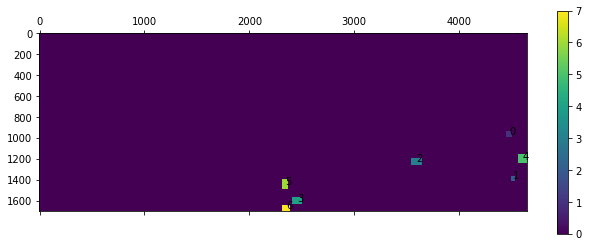

{0: ((4449, 4505, 938, 1002), 3705),
 1: ((4490, 4532, 1365, 1415), 2180),
 2: ((3542, 3644, 1195, 1262), 7004),
 3: ((2409, 2502, 1572, 1633), 5828),
 4: ((4559, 4646, 1158, 1250), 8158),
 5: ((2317, 2372, 1400, 1490), 5096),
 6: ((2317, 2387, 1648, 1702), 3905)}

In [4]:
plt.figure(figsize=(20, 12))
imze.list_regions()

In [29]:
spectra_orig2 = imze.get_region_array(2, makeNullLine=True)


Found region 2 with shape (103, 68, 38800)


In [5]:
avg_region_spectrum = imze.get_avg_region_spectrum(2)

Found region 2 with shape (103, 68, 38800)


In [6]:
sp2_called, sp2_called_masses = imze.to_called_peaks(np.array([[avg_region_spectrum]]), imze.mzValues, resolution=4)

100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


459.90595210980695 2000.2994838848333
460.0 2000.25
(1, 1, 6162)
(6162,)


In [7]:
spectra_orig4 = imze.get_region_array(4, makeNullLine=True)
sh_sporig_bg4, sh_masses_sporig_bg4 = imze.shift_region_array(spectra_orig4, imze.mzValues, maxshift=20)
sp4_called, sp4_called_masses = imze.to_called_peaks(sh_sporig_bg4, sh_masses_sporig_bg4, resolution=4)
sp4_called_nobg, sp4_called_nobg_masses = imze.remove_background_spec_aligned(sp4_called, sp2_called[0,0,2:-4], sp4_called_masses, 5)

Found region 4 with shape (88, 93, 38800)
100% (8184 of 8184) |####################| Elapsed Time: 0:00:05 Time:  0:00:05


Shifts: mean: 11.789589442815249, median: 13.0


N/A% (0 of 88) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

460.6999898591175 1999.5054461355228
460.75 1999.5
(88, 93, 6156)
(6156,)


100% (88 of 88) |########################| Elapsed Time: 0:03:51 Time:  0:03:51
|###########                                              |  20% ETA:   0:00:00

(6156,)
(88, 93, 6156)


|#########################################################| 100% Time:  0:00:00


avg shift 0.009408602150537635


In [8]:
spectra_orig3 = imze.get_region_array(3, makeNullLine=True)
sh_sporig_bg3, sh_masses_sporig_bg3 = imze.shift_region_array(spectra_orig3, imze.mzValues, maxshift=20)
sp3_called, sp3_called_masses = imze.to_called_peaks(sh_sporig_bg3, sh_masses_sporig_bg3, resolution=4)
sp3_called_nobg, sp3_called_nobg_masses = imze.remove_background_spec_aligned(sp3_called, sp2_called[0,0,3:-3], sp3_called_masses, 5)

Found region 3 with shape (94, 62, 38800)
100% (5828 of 5828) |####################| Elapsed Time: 0:00:03 Time:  0:00:03


Shifts: mean: -1.4826698695950584, median: -1.0


N/A% (0 of 94) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

460.6999898591175 1999.5054461355228
460.75 1999.5
(94, 62, 6156)
(6156,)


100% (94 of 94) |########################| Elapsed Time: 0:00:30 Time:  0:00:30
|##############                                           |  25% ETA:   0:00:00

(6156,)
(94, 62, 6156)


|#########################################################| 100% Time:  0:00:00


avg shift 0.004804392587508579


In [9]:
sp3_called_nobg_norm = imze.normalize_region_array(sp3_called_nobg, normalize="vector")

In [10]:
np.array([1,1,1,1]) / np.array([2,2,2,2])

array([0.5, 0.5, 0.5, 0.5])

In [11]:
sp3_called_nobg_norm_intra = imze.normalize_region_array(sp3_called_nobg, normalize="intra_median")

Got 0 median-enabled pixels


In [13]:
sp3_called_nobg_norm_inter = imze.normalize_region_array(sp3_called_nobg_norm_intra, normalize="inter_median")

Got a total of 35818888 fold changes
Median elements [17909444]
Median elements
Global Median 0.0


intra/inter normalization does not have any effect, because median == 0!

459.90595210980695 154
476.6601486202598 4
483.64768081419277 31
490.63521300812573 3014
497.6227452020587 2594
504.5705755085261 8
506.9526887564578 1
507.03209253138886 1
511.55810770245904 3
512.987375651218 1
513.0270775386836 13
513.3049907509424 1
518.545639896392 3


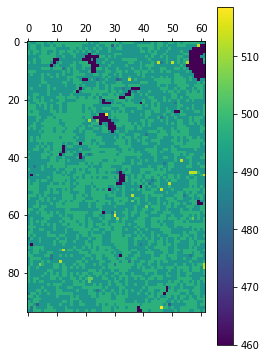

5828 0.0 1.0 0.47724874037229476


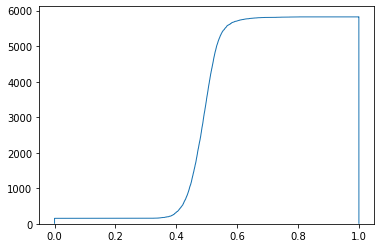

In [14]:
imze.list_highest_peaks(sp3_called_nobg_norm, counter=True)

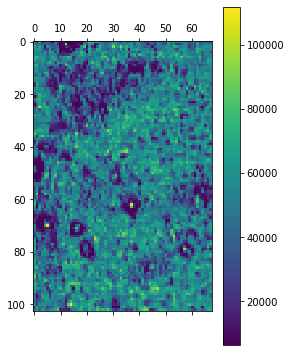

In [30]:
imze.plot_toc(spectra_orig2)

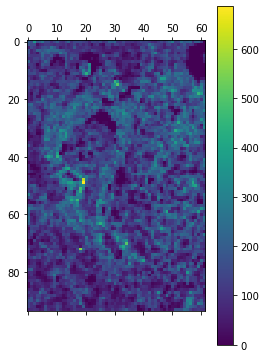

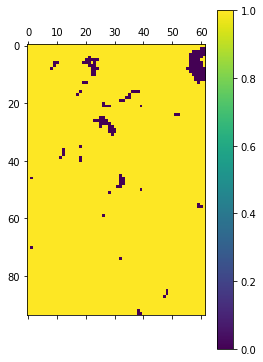

In [48]:
imze.plot_tnc(sp3_called_nobg)
imze.plot_tnc(sp3_called_nobg_norm)

In [46]:
sp3_called_nobg_norm = imze.normalize_region_array(sp3_called_nobg, normalize="vector")

print(np.linalg.norm(sp3_called_nobg[0,0,:]))
print(np.linalg.norm(sp3_called_nobg_norm[0,0,:]))


201.59079901696495
1.0


In [15]:
def plot_coords(arr, coords, valRange, xvals):
    for x in coords:
        plt.plot(xvals, arr[x], label=str(x))
        
    plt.xlim(valRange)
    plt.legend()
    
def plot_coords_vec(arr, valRange, xvals):       
    plt.plot(xvals[valRange], arr[valRange], label="(00, 00)")
    plt.legend()

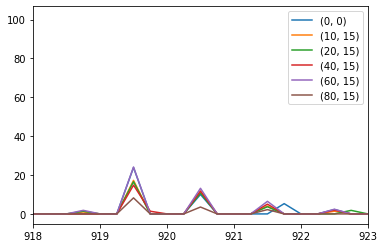

In [16]:
plot_coords(sp3_called, [(0,0),(10,15), (20,15), (40,15), (60,15), (80,15)], (918,923), sp3_called_masses)

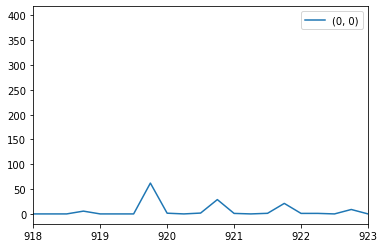

In [17]:
plot_coords(sp2_called[:,:,3:-3], [(0,0)], (918,923), sp2_called_masses[4:-2])

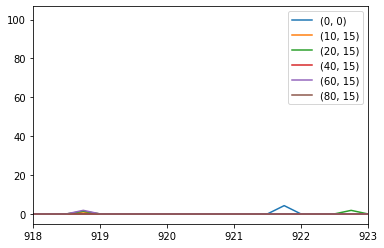

In [18]:
plot_coords(sp3_called_nobg, [(0,0),(10,15), (20,15), (40,15), (60,15), (80,15)], (918,923), sp3_called_nobg_masses)

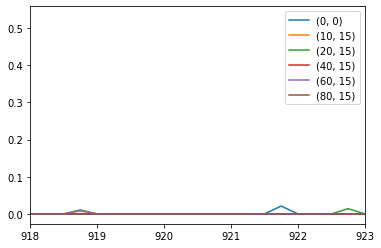

In [19]:
plot_coords(sp3_called_nobg_norm, [(0,0),(10,15), (20,15), (40,15), (60,15), (80,15)], (918,923), sp3_called_nobg_masses)

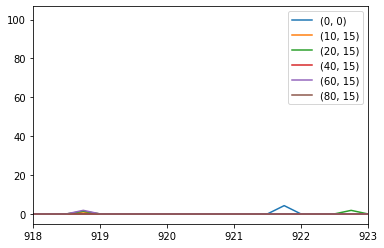

In [20]:
plot_coords(sp3_called_nobg_norm_intra, [(0,0),(10,15), (20,15), (40,15), (60,15), (80,15)], (918,923), sp3_called_nobg_masses)

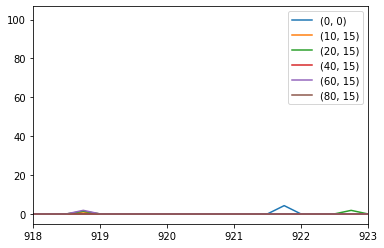

In [21]:
plot_coords(sp3_called_nobg_norm_inter, [(0,0),(10,15), (20,15), (40,15), (60,15), (80,15)], (918,923), sp3_called_nobg_masses)

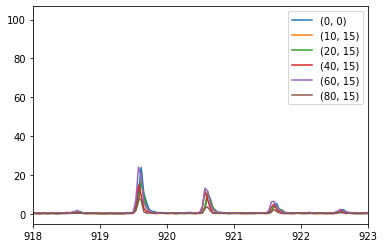

In [22]:
plot_coords(sh_sporig_bg3, [(0,0),(10,15), (20,15), (40,15), (60,15), (80,15)], (918,923), sh_masses_sporig_bg3)

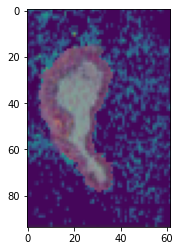

In [23]:
aorta_mask_blended = np.round(imageio.imread("aorta_mask_blended.png"))
plt.imshow(aorta_mask_blended)

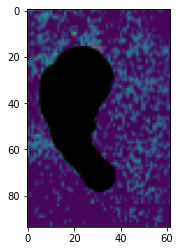

In [24]:
aorta_mask_blended = np.round(imageio.imread("aorta_mask_blended_mask.png"))
plt.imshow(aorta_mask_blended)

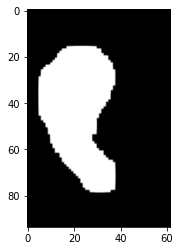

In [25]:
manual_mask = ~np.round(imageio.imread("aorta_test_lipids_2.png"))
plt.imshow(manual_mask)

In [ ]:
spec_4= SpectraRegion(sp4_called_nobg, sp4_called_nobg_masses)
spec_4.calculate_similarity(mode="spectra_log")

In [ ]:
spec_4.segment(method="WARD", number_of_regions=10)

In [ ]:
spec_4.plot_segments()

In [ ]:
spec_percentile=None

Let's see whether the unsupervised approach works better now?

In [ ]:
spec_3 = SpectraRegion(sp3_called_nobg, sp3_called_nobg_masses)
spec_3.calculate_similarity(mode="spectra_log")

In [ ]:
spec_3.segment(method="WARD", number_of_regions=10)

In [ ]:
spec_3.plot_segments()

Not really - maybe UMAP+DBSCAN?

In [ ]:
spec_3.segment(method="UMAP_DBSCAN",number_of_regions=None,min_cluster_size=5, min_samples=None, n_neighbors=15)

In [ ]:
projection = spec_3.dimred_elem_matrix#umap.UMAP().fit_transform(spec_percentile.dimred_elem_matrix)

clusterer = hdbscan.HDBSCAN(min_cluster_size=20, prediction_data=True,gen_min_span_tree=True).fit(spec_3.dimred_elem_matrix)

soft_clusters = hdbscan.all_points_membership_vectors(clusterer)

cluster_labels = [np.argmax(x) for x in soft_clusters]

uniqueLabels = sorted(set(cluster_labels))
numLabels = len(cluster_labels)

cluster_colors = [x/len(uniqueLabels) for x in cluster_labels]

mpl.rcParams['figure.figsize'] = (25,10)
sp = plt.scatter(*projection.T, s=15, linewidth=0, c=cluster_colors, cmap="viridis", alpha=0.25)

valid_vals = np.unique(cluster_colors)
min_ = min(valid_vals)
max_ = max(valid_vals)

print(min_, max_)

positions = np.linspace(min_, max_, len(valid_vals))
val_lookup = dict(zip(positions, valid_vals))

def formatter_func(x, pos):
    'The two args are the value and tick position'
    val = val_lookup[x] * len(valid_vals)
    return val

formatter = plt.FuncFormatter(formatter_func)
plt.colorbar(sp, ticks=positions, format=formatter, spacing='proportional')

mpl.rcParams['figure.figsize'] = (6,4)

print(numLabels)
print(sum(clusterer.labels_ == -1))


In [ ]:
hdblabels = np.reshape(cluster_labels, (94,62))
spec_3.plot_array(plt.gcf(), hdblabels)

Also does not work ... supervised?

In [ ]:
manual_mask = 1-np.round(rgb2gray(rgba2rgb(imageio.imread("aorta_test_lipids_2.png"))))
plt.imshow(manual_mask)

In [ ]:
shapePixels = set()
bgPixels = set()

for x in range(0, spectra_orig3.shape[0]):
    for y in range(0, spectra_orig3.shape[1]):
        
        if manual_mask[x,y] >= 0.5:
            shapePixels.add((x,y))
        else:
            bgPixels.add((x,y))

In [ ]:
spectra = np.array(sp3_called_nobg)
spectra_masses = np.array(sp3_called_nobg_masses)

In [ ]:
print("Included pixels", len(shapePixels), len(bgPixels))

testPixels_aorta = random.sample(shapePixels, 300)
testPixels_bg = random.sample(bgPixels, 300)

In [ ]:

values_train = []
classes_train = []

values_test = []
classes_test = []

values_all = []
classes_all = []

for x in range(0, spectra.shape[0]):
    for y in range(0, spectra.shape[1]):
        
        if (x,y) in testPixels_aorta:
            values_test.append(spectra[x,y,:])
            classes_test.append(1)
            continue           
        if (x,y) in testPixels_bg:
            values_test.append(spectra[x,y,:])
            classes_test.append(0)
            continue
        
        if manual_mask[x,y] < 0.5:
            
            values_train.append(spectra[x,y,:])
            classes_train.append(0)
            
            values_all.append(spectra[x,y,:])
            classes_all.append(0)
            
        else:
            
            values_train.append(spectra[x,y,:])
            classes_train.append(1)
            
            values_all.append(spectra[x,y,:])
            classes_all.append(1)
        
        
print("Train size", len(values_train))
print("Test size", len(values_test))

In [ ]:
subsetIdx = random.sample([x for x in range(0, len(values_train))], 600)
subsetIdx = [x for x in range(0, len(values_train))]

values_train_sub = []
classes_train_sub = []

for sIdx in subsetIdx:
    values_train_sub.append( values_train[sIdx] )
    classes_train_sub.append( classes_train[sIdx] )
    
print("Subsetted", len(values_train_sub))

In [ ]:
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(values_all, classes_all)

In [ ]:
graph = Source(tree.export_graphviz(clf, out_file=None
   , class_names=['0', '1'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

In [ ]:
treeMasses = set()
for mzIdx in [617,967,1079,4492,1567,4505,4625,1530,1514,1303,1341]:
    mzVal = spec_3.idx2mass[mzIdx]
    
    print(mzIdx, mzVal)
    treeMasses.add(mzVal)
    spec_3.mass_heatmap(mzVal)

In [ ]:
trues = np.zeros((spectra.shape[0], spectra.shape[1]))

trueEvals = 0

for x in range(0, spectra.shape[0]):
    for y in range(0, spectra.shape[1]):
        
        
        retVal = clf.predict_proba([ spectra[x,y,:] ])[0]
        pred_label = np.argmax(retVal)
        
        if pred_label == 1:
            trues[x,y] = 1
            
        if pred_label == manual_mask[x,y]:
            trueEvals += 1
            
print(trueEvals, spectra.shape[0]*spectra.shape[1], trueEvals / (spectra.shape[0]*spectra.shape[1]))
plt.imshow(trues)

In [ ]:
#617.1254264732984
#741.5511417902636
mm = np.round(rgb2gray(rgba2rgb(imageio.imread("aorta_test_lipids_2.png"))))

plt.matshow(spec_3.mass_heatmap(703.75, plot=False)*0.1+mm)

In [ ]:
def eval_mass(mass, intens, comp, spectra, manual, weights=None):
    
    if weights == None:
        weights = (1,1)
    #bg if comp True
    
    bgPixels = 0
    shapePixels = 0
    
    bgCorr = 0
    bgIncorr = 0
    
    shapeCorr = 0
    shapeIncorr = 0

    for x in range(0, spectra.shape[0]):
        for y in range(0, spectra.shape[1]):
            
            pred = 1 if comp(spectra[x,y,mass], intens) else 0
            
            if manual[x,y] == 1:
                shapePixels += 1
                
                if pred == 1:
                    shapeCorr += 1
                else:
                    shapeIncorr += 1
                
            if manual[x,y] == 0:
                bgPixels += 1
                
                if pred == 0:
                    bgCorr += 1
                else:
                    bgIncorr += 1
            
    #print(bgCorr, bgIncorr, bgPixels)    
    #print(shapeCorr, shapeIncorr, shapePixels)    
    
    avgPixels = (bgPixels + shapePixels)/2
        
    bgCorrRate = bgCorr / bgPixels
    shapeCorrRate = shapeCorr / shapePixels
    
    return (weights[0]*shapeCorrRate + weights[1]*bgCorrRate) / sum(weights)

In [ ]:
percentileMassIndices = []
supervisedPercentileIndices = []

bar = progressbar.ProgressBar(widgets=[
        progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
    ])

bgCount = sum(sum(manual_mask == 1))
shapeCount = sum(sum(manual_mask == 0))

for mass in bar(range(0, spectra.shape[2])):
        
    bgValues = [spectra[x,y,mass] for (x,y) in bgPixels]
    shapeValues = [spectra[x,y,mass] for (x,y) in shapePixels]
    
    bgMean = np.mean(bgValues)
    shapeMean = np.mean(shapeValues)
    
    intenseThreshold = (bgMean + shapeMean) / 2.0
    ec = eval_mass(mass, intens=intenseThreshold, comp=lambda x,y: x>y, spectra=spectra, manual=manual_mask, weights = (2, 1) )
    
    pcVals = np.percentile(bgValues+shapeValues, [85, 99])
    
    if pcVals[1]-pcVals[0] > 0.01 and pcVals[0] < 0.0001:
        percentileMassIndices.append(mass)
        
        if len(percentileMassIndices) > 0 and len(percentileMassIndices) % 10 == 0:
            print("masses", len(percentileMassIndices))

    if ec > 0.7:
        print(mass, ec, bgMean, shapeMean)
        supervisedPercentileIndices.append(mass)
        

    
print("Found percentile masses", len(percentileMassIndices))

In [ ]:
print(spec_3.idx2mass[967])
plt.imshow(spec_3.mass_heatmap(703.75, plot=False) > 1.5)

In [ ]:
fcIndices = percentileMassIndices#percentileMassIndices

percentile_peaks = spectra[:,:,fcIndices]
percentile_masses = spectra_masses[fcIndices]

percentile_peaks.shape

In [ ]:
spec_percentile = SpectraRegion(percentile_peaks, percentile_masses)
spec_percentile.calculate_similarity(mode="spectra_log")


In [ ]:
spec_percentile.segment(method="WARD", number_of_regions=5)

In [ ]:
spec_percentile.plot_segments()

In [ ]:
spec_percentile.segment(method="UMAP_DBSCAN",number_of_regions=None,min_cluster_size=5, min_samples=None, n_neighbors=15)

In [ ]:
projection = spec_percentile.dimred_elem_matrix#umap.UMAP().fit_transform(spec_percentile.dimred_elem_matrix)

clusterer = hdbscan.HDBSCAN(min_cluster_size=80, prediction_data=True,gen_min_span_tree=True).fit(spec_percentile.dimred_elem_matrix)

soft_clusters = hdbscan.all_points_membership_vectors(clusterer)

cluster_labels = [np.argmax(x) for x in soft_clusters]

uniqueLabels = sorted(set(cluster_labels))
numLabels = len(cluster_labels)

cluster_colors = [x/len(uniqueLabels) for x in cluster_labels]

mpl.rcParams['figure.figsize'] = (25,10)
sp = plt.scatter(*projection.T, s=15, linewidth=0, c=cluster_colors, cmap="viridis", alpha=0.25)

valid_vals = np.unique(cluster_colors)
min_ = min(valid_vals)
max_ = max(valid_vals)

print(min_, max_)

positions = np.linspace(min_, max_, len(valid_vals))
val_lookup = dict(zip(positions, valid_vals))

def formatter_func(x, pos):
    'The two args are the value and tick position'
    val = val_lookup[x] * len(valid_vals)
    return val

formatter = plt.FuncFormatter(formatter_func)
plt.colorbar(sp, ticks=positions, format=formatter, spacing='proportional')

mpl.rcParams['figure.figsize'] = (6,4)

print(numLabels)
print(sum(clusterer.labels_ == -1))


In [ ]:
hdblabels = np.reshape(cluster_labels, (94,62))
spec_percentile.plot_array(plt.figure(), hdblabels)